In this notebook we will implement the word generation by LSTM model frame by frame as discussed in the given article:

https://towardsdatascience.com/language-modeling-with-lstms-in-pytorch-381a26badcbf

In [1]:
%autosave 300
%reload_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os

os.chdir(
    "/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_pytorch_nlp"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_pytorch_nlp


In [3]:
os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [4]:
import torch
from torchinfo import summary
import torchtext
import os
import json
from collections import Counter
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import ngrams_iterator
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import re
from torchview import draw_graph
from torcheval.metrics import MulticlassAccuracy, BinaryAccuracy
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from src.pytorch_helpers import *
from torch.optim import Adam

plt.rcParams["figure.figsize"] = (25, 20)

In [5]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 100)
pd.set_option("display.max_colwidth", 100)
import re
import string
from string import digits

In [28]:
# Set manual seed since nn.Parameter are randomly initialzied
set_seed(42)
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
epochs = 10
lr = 1e-3
batch_size = 64
input_batch = 128

Random seed set as 42
cuda


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import torchtext
import datasets
from tqdm import tqdm

In [8]:
dataset = datasets.load_dataset('wikitext', 'wikitext-2-raw-v1')
print(dataset)

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})


In [9]:
dataset["test"][3]

{'text': ' Robert Boulter is an English film , television and theatre actor . He had a guest @-@ starring role on the television series The Bill in 2000 . This was followed by a starring role in the play Herons written by Simon Stephens , which was performed in 2001 at the Royal Court Theatre . He had a guest role in the television series Judge John Deed in 2002 . In 2004 Boulter landed a role as " Craig " in the episode " Teddy \'s Story " of the television series The Long Firm ; he starred alongside actors Mark Strong and Derek Jacobi . He was cast in the 2005 theatre productions of the Philip Ridley play Mercury Fur , which was performed at the Drum Theatre in Plymouth and the Menier Chocolate Factory in London . He was directed by John Tiffany and starred alongside Ben Whishaw , Shane Zaza , Harry Kent , Fraser Ayres , Sophie Stanton and Dominic Hall . \n'}

Tokenization

In [10]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")
tokenize_data = lambda example, tokenizer: {"tokens": tokenizer(example["text"])}
tokenized_data = dataset.map(
    tokenize_data, remove_columns=["text"], fn_kwargs={"tokenizer": tokenizer}
)

In [15]:
print(tokenized_data['train'][88]['tokens'])

{'tokens': ['this', 'ammunition', ',', 'and', 'that', 'which', 'i', 'brought', 'with', 'me', ',', 'was', 'rapidly', 'prepared', 'for', 'use', 'at', 'the', 'laboratory', 'established', 'at', 'the', 'little', 'rock', 'arsenal', 'for', 'that', 'purpose', '.', 'as', 'illustrating', 'as', 'the', 'pitiful', 'scarcity', 'of', 'material', 'in', 'the', 'country', ',', 'the', 'fact', 'may', 'be', 'stated', 'that', 'it', 'was', 'found', 'necessary', 'to', 'use', 'public', 'documents', 'of', 'the', 'state', 'library', 'for', 'cartridge', 'paper', '.', 'gunsmiths', 'were', 'employed', 'or', 'conscripted', ',', 'tools', 'purchased', 'or', 'impressed', ',', 'and', 'the', 'repair', 'of', 'the', 'damaged', 'guns', 'i', 'brought', 'with', 'me', 'and', 'about', 'an', 'equal', 'number', 'found', 'at', 'little', 'rock', 'commenced', 'at', 'once', '.', 'but', ',', 'after', 'inspecting', 'the', 'work', 'and', 'observing', 'the', 'spirit', 'of', 'the', 'men', 'i', 'decided', 'that', 'a', 'garrison', '500', 's

Vocabularization

In [22]:
sen_tokens = tokenized_data["train"]["tokens"]
vocabulary = torchtext.vocab.build_vocab_from_iterator(sen_tokens, min_freq=2)
vocabulary.insert_token("<unk>", 0)
vocabulary.insert_token("<eos>", 1)
vocabulary.set_default_index(vocabulary["<unk>"])
print(len(vocabulary))

39135


Batch DataPrep

In [38]:
def get_data(dataset, vocabulary, input_batch):
    data = []

    for example in dataset:
        if example["tokens"]:
            tokens = example["tokens"]
            tokens = [vocabulary[token] for token in tokens]
            tokens.append(vocabulary["<eos>"])
            data.extend(tokens)

    data = torch.tensor(data, dtype=torch.long).to(device)
    print(data.size())
    num_batches = data.size(0) // input_batch
    print(num_batches)
    data = data[: num_batches * input_batch]
    data = data.view(input_batch, num_batches)
    return data

In [36]:
train_data = get_data(tokenized_data["train"], vocabulary, input_batch)
val_data = get_data(tokenized_data["validation"], vocabulary, input_batch)
test_data = get_data(tokenized_data["test"], vocabulary, input_batch)

torch.Size([2075432])
16214
torch.Size([217126])
1696
torch.Size([245047])
1914


In [34]:
print(train_data.size())
print(val_data.size())
print(test_data.size())

torch.Size([128, 16214])
torch.Size([128, 1696])
torch.Size([128, 1914])


Model Building

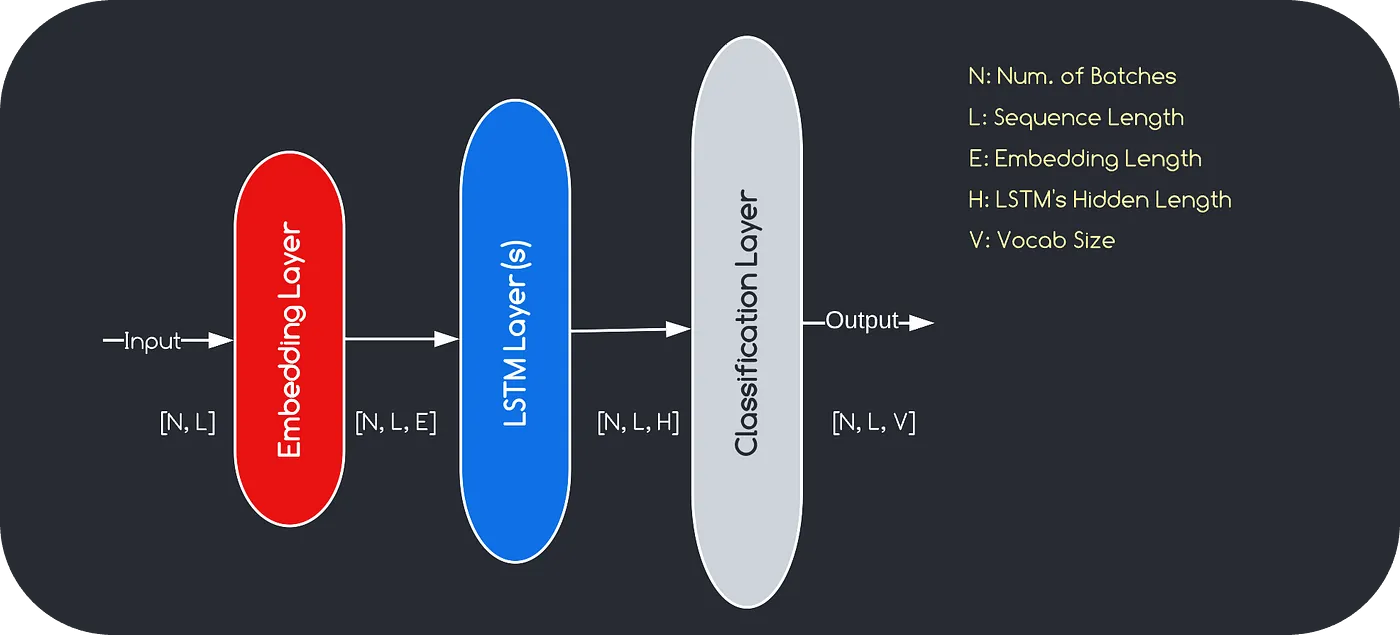